<img src="https://raw.githubusercontent.com/inverted-ai/invertedai/master/docs/images/banner-small.png" alt="InvertedAI" width="200"/>


In [1]:
import sys
sys.path.insert(0, "..")

import IPython
from IPython.display import display, Image, clear_output
from ipywidgets import interact

import matplotlib.pyplot as plt
import imageio
import numpy as np
import cv2 
import invertedai as iai
from IPython.utils import io
import time

http://0.0.0.0:8001


In [2]:
# API key:
# iai.add_apikey("")

In [3]:
# pick a location (4 way, signalized intgersection)
location = "iai:drake_street_and_pacific_blvd"

In [4]:
location_info_response = iai.location_info(location=location)
rendered_static_map = location_info_response.birdview_image.decode()
scene_plotter = iai.utils.ScenePlotter(rendered_static_map, 
                                       location_info_response.map_fov, 
                                       (location_info_response.map_center.x, location_info_response.map_center.y), 
                                       location_info_response.static_actors)

In [5]:
collisions = None

# Simulate with `initialize`, `drive` and `light` until there are collisions.
while collisions is None:
    light_response = iai.light(location=location)

    response = iai.initialize(
        location=location,  
        agent_count=25,    
        get_birdview=True,  
        traffic_light_state_history=[light_response.traffic_lights_states]  
    )
    agent_attributes = response.agent_attributes  
    scene_plotter.initialize_recording(response.agent_states, 
                                       agent_attributes=agent_attributes, 
                                       traffic_light_states=light_response.traffic_lights_states)

    agent_state_history = []
    traffic_light_state_history = []

    # 20-second scene
    for _ in range(200):  
        light_response = iai.light(location=location, recurrent_states=light_response.recurrent_states)
        response = iai.drive(
            location=location,
            agent_attributes=agent_attributes,
            agent_states=response.agent_states,
            recurrent_states=response.recurrent_states,
            get_birdview=True,
            traffic_lights_states=light_response.traffic_lights_states,
            get_infractions=True,
            random_seed=1
        )
        scene_plotter.record_step(response.agent_states, traffic_light_states=light_response.traffic_lights_states)
        agent_state_history.append(response.agent_states)
        traffic_light_state_history.append(light_response.traffic_lights_states)
    
    
    blame_response = iai.blame(
        location=location,
        candidate_agents=[0, 0],
        agent_state_history=agent_state_history,
        agent_attributes=agent_attributes,
        traffic_light_state_history=traffic_light_state_history,
        get_birdviews=True,
        detect_collisions=True
    )
    collisions = blame_response.blamed_collisions
    

print(collisions)

[((0, 3), (89, 96), (0,)), ((2, 17), (135, 150), (2,)), ((3, 5), (150, 162), (3,)), ((4, 11), (1, 15), (11,)), ((4, 21), (61, 61), (21,)), ((11, 21), (16, 29), (21,)), ((12, 17), (193, 196), (12,)), ((17, 22), (120, 121), (22,))]


In [6]:
# %%capture
# gif_name = 'iai-drive-side-road-green.gif'
# fig, ax = plt.subplots(constrained_layout=True, figsize=(15, 15))
# scene_plotter.animate_scene(output_name=gif_name, ax=ax,
#                             numbers=False, direction_vec=False, velocity_vec=False,
#                             plot_frame_number=True)

In [7]:
# Image(gif_name)

In [8]:
idx = 0
collision = collisions[idx]
blame_response = iai.blame(
    location=location,
    candidate_agents=collision[0],
    agent_state_history=agent_state_history[:collision[1][0]],
    traffic_light_state_history=traffic_light_state_history[:collision[1][0]],
    agent_attributes=agent_attributes,
    get_reasons=True,
    get_confidence_score=True,
    get_birdviews=True,
    detect_collisions=False
)
print(blame_response.blamed_result)

(0,)


In [9]:
blame_response.reasons

{0: ['traffic_light_violation']}

In [10]:
blame_response.confidence_score

0.4857044816017151

In [11]:
%%capture
fig, ax = plt.subplots(constrained_layout=True, figsize=(15, 15))
gif_name = 'part-iai-drive-side-road-green.gif'
scene_plotter.animate_scene(output_name=gif_name, ax=ax, 
                            start_idx=max(0, collision[1][0] - 50), end_idx=collision[1][1],
                            numbers=list(collision[0]), direction_vec=False, velocity_vec=False,
                            plot_frame_number=True)

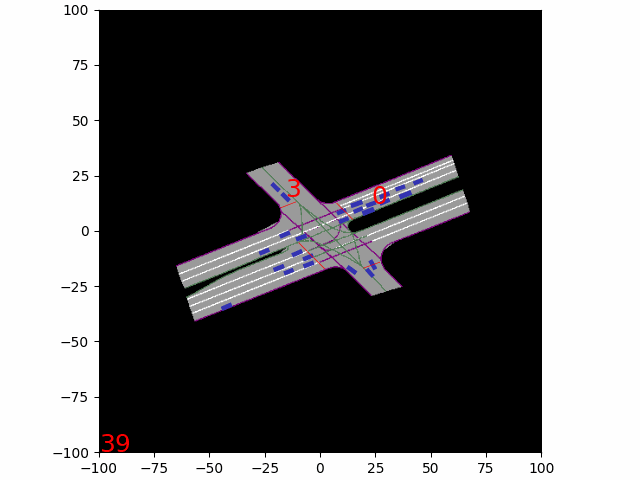

In [12]:
Image(gif_name)